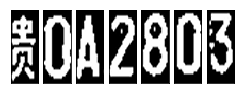

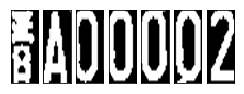

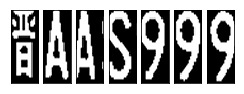

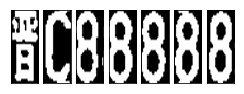

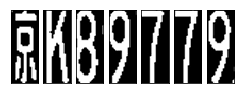

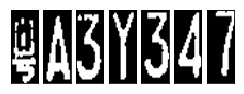

In [21]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from pylab import mpl
 
def Process(img):
    # 高斯平滑
    gaussian = cv2.GaussianBlur(img, (3, 3), 0, 0, cv2.BORDER_DEFAULT)
    # 中值滤波
    median = cv2.medianBlur(gaussian, 3)
    # Sobel算子
    # 梯度方向: x
    sobel = cv2.Sobel(median, cv2.CV_8U, 1, 0, ksize=3)
    # 二值化
    mean = (np.max(sobel) + np.min(sobel)) / 2
    ret, binary = cv2.threshold(sobel, mean, 255, cv2.THRESH_BINARY)
    # 核函数(9,1)(10,8)
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 1))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 8))
    # 膨胀
    dilation = cv2.dilate(binary, element2, iterations=1)
    # 腐蚀
    erosion = cv2.erode(dilation, element1, iterations=1)
    # 膨胀
    dilation2 = cv2.dilate(erosion, element2, iterations=1)
    return dilation2

def GetRegion(img):
    regions = []
    # 查找轮廓
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv2.contourArea(contour)
        # 根据面积筛选
        if area < 600 or area > 8000:
            continue
        # 寻找相似的更小的矩形
        eps = 1 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, eps, True)
        rect = cv2.minAreaRect(contour)
        # 获取矩形的四个点坐标
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        # 计算高度和宽度
        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])
        # 高宽比
        ratio =float(width) / float(height)
        if ratio < 10 and ratio > 1.3:
            regions.append(box)
    return regions
 
 
def detect(img):
    img1 = img.copy()
    
    # 灰度化
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    prc = Process(gray)
    regions = GetRegion(prc)
    
    cv2.drawContours(img1, regions, -1, (0, 255, 0), 2)
    cv2.imshow('image', img1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    max_i = 0
    max_mask = 0
    car_number = 0
    for i in range(len(regions)):
        # 获取对角线两个坐标
        min_b = np.min(regions[i], axis=0)
        max_b = np.max(regions[i], axis=0)
        piece = img[min_b[1]:max_b[1], min_b[0]:max_b[0]]
        # 转换颜色空间，以便获取蓝色车牌
        hsv = cv2.cvtColor(piece, cv2.COLOR_BGR2HSV)
        #蓝色车牌的范围
        lower = np.array([100,50,50])
        upper = np.array([140,255,255])
        #根据阈值构建掩膜
        mask = cv2.inRange(hsv, lower, upper)
        if np.sum(mask) > max_mask:
            max_i = i
            max_mask = np.sum(mask)
            car_number = piece
    return car_number
# 旋转校正
def rotate_image(img, angle):
    if img.shape[0] > 70:
        img = img[30:img.shape[0]-20, :]
    w, h = img.shape[0:2]
    center = (w // 2, h // 2)
    # 获取旋转的矩阵
    wrapMat = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, wrapMat, (h, w))

def correct(car_plates):
    car_num = []
    for picture in car_plates:
        # 灰度化
        each_gray = cv2.cvtColor(picture, cv2.COLOR_BGR2GRAY)
        #腐蚀、膨胀
        kernel = np.ones((3,3), np.uint8)
        erode_img = cv2.erode(each_gray, kernel)
        dilate_img = cv2.dilate(erode_img, kernel)
        #边缘检测
        canny = cv2.Canny(dilate_img, 100, 200)
        # 霍夫变换检测直线
        lines = cv2.HoughLinesP(canny, 0.8, np.pi/180, 30,
                                minLineLength=10, maxLineGap=10)
        x1, y1, x2, y2 = lines[0][0]
        # 求斜率
        tan = (y1 - y2)/(x1 - x2)
        # 得到旋转角度
        thera = np.degrees(math.atan(tan))
        rotate_car = rotate_image(each_gray, thera)
        rotate_car = cv2.resize(rotate_car, (175,70), interpolation=cv2.INTER_CUBIC)
        car_num.append(rotate_car)
    return car_num

def plate_cut(car_plates):
    w, h = 175, 70
    j = 0
    for index, car in enumerate(car_plates):
        cut = []
        gray_img = cv2.GaussianBlur(car, (3, 3), 0, 0, cv2.BORDER_DEFAULT)
        
        # 拉普拉斯算法图像增强
        kernel = np.array([ [0, -1, 0],   [-1,  5, -1],   [0, -1, 0] ]) 
        gray_img = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)

        #二值化处理
        thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
        
        #腐蚀、膨胀
        kernel = np.ones((2,1), np.uint8)
        thresh = cv2.erode(thresh, kernel)
        thresh = cv2.dilate(thresh, kernel)
        
        frin = [[(15, 48), (23, 164)], [(20, 50), (20, 170)], [(10, 48), (2, 156)],
               [(20, 54), (16, 170)], [(14, 60), (10, 146)], [(13, 53), (5, 154)]]

        x, y = frin[index][0:]
        thresh = thresh[x[0]:x[1], y[0]:y[1]]
        thresh = cv2.resize(thresh, (200,70), interpolation=cv2.INTER_CUBIC)
        
        start = 0
        fig = plt.figure(figsize=(4, 2))
        for i in range(7):
            if i == 2:
                start = start + 16
            cut.append(thresh[:, start:start+26])
            start = start + 26
        for i, c in enumerate(cut):
            plt.subplot(1, 7, i+1)
            plt.imshow(c, cmap='gray')
            plt.xticks([])
            plt.yticks([])
        plt.show()

if __name__ == '__main__':
    name = ['贵OA2803.jpg', '晋A00002.jpg', '晋AAS999.jpg', '晋C88888.jpg', '京K89779.jpg',
           '粤A3Y347.jpg']
    path = 'E:\\homework\\DigitImage\\大作业12.8交\\车牌\\III类\\'
    car_plates = []
    #输入的参数为图片的路径
    for i in name:
        img = cv2.imdecode(np.fromfile(path + i, dtype=np.uint8), -1)
        p = detect(img)
        car_plates.append(p)
    car_plates = correct(car_plates)
    plate_cut(car_plates)